In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cvxpy as cp
from statsmodels.tsa.ar_model import AutoReg
from scipy import stats

In [146]:
import mne

# Q1

Extracting EDF parameters from /Users/yuanyuqi/Desktop/UC_Berkeley_sp25/STAT153/hw04/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /Users/yuanyuqi/Desktop/UC_Berkeley_sp25/STAT153/hw04/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /Users/yuanyuqi/Desktop/UC_Berkeley_sp25/STAT153/hw04/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


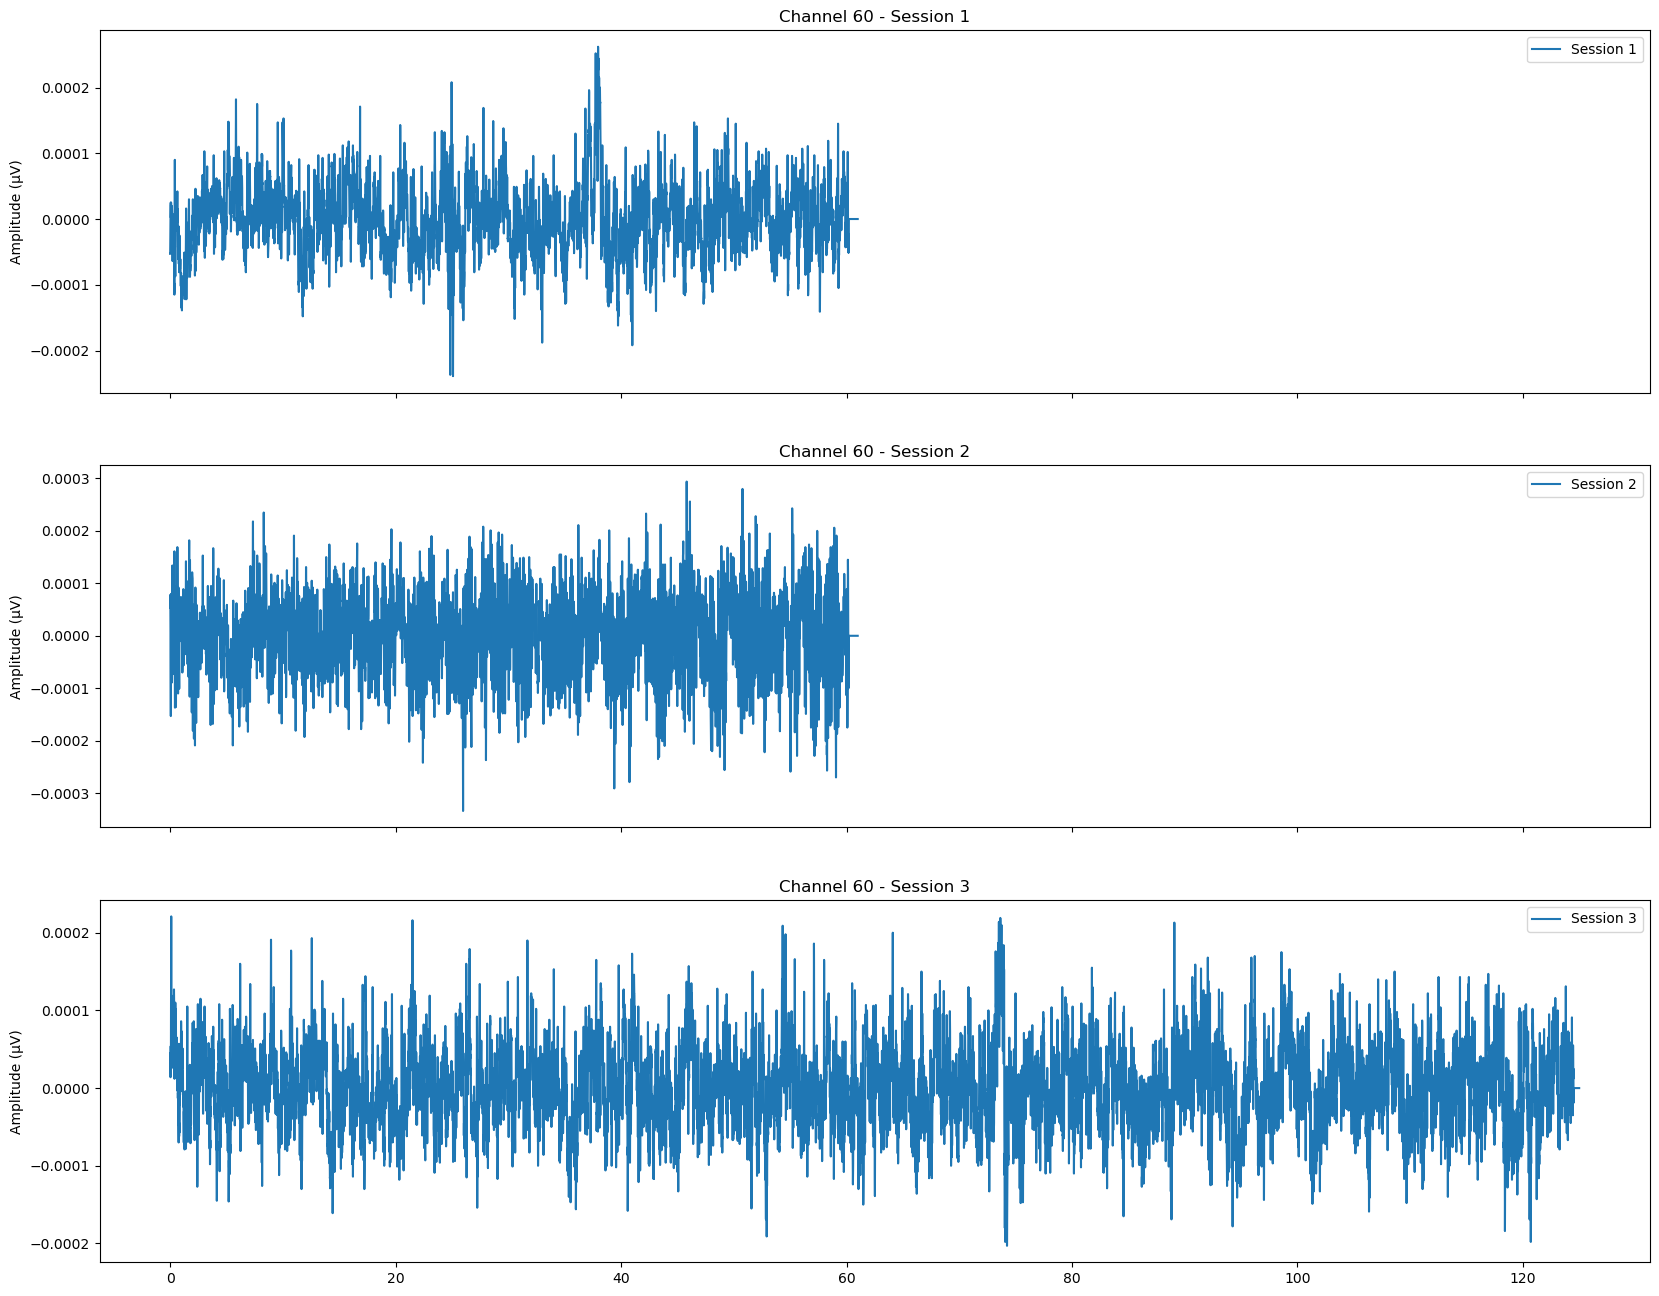

In [147]:
#(a)
raw_1 = mne.io.read_raw_edf('S001R01.edf', preload = True)
raw_2 = mne.io.read_raw_edf('S001R02.edf', preload = True)
raw_3 = mne.io.read_raw_edf('S001R05.edf', preload = True)
data_1, times_1 = raw_1[:]
data_2, times_2 = raw_2[:]
data_3, times_3 = raw_3[:]

ch_index = 60  # pick a channel 

fig, ax = plt.subplots(3, 1, figsize=(20, 16), sharex=True)
for i in range(3):
    if i == 0:
        data = data_1
        times = times_1
    elif i == 1:
        data = data_2
        times = times_2
    else:
        data = data_3
        times = times_3

    ax[i].plot(times, data[ch_index, :], label=f"Session {i+1}")
    ax[i].set_title(f"Channel {ch_index} - Session {i+1}")
    ax[i].set_ylabel("Amplitude (µV)")
    ax[i].legend()

for session 2 (which is eyes closed), the fluctutation amplitude seems to be more regular than the other two sessions. While for the session 3 the fluctuation of amplitude seems to be the most intense of the three sessions.

In [148]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y

def spectrum_estimator_ridge(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y)
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

def spectrum_estimator_lasso(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y) 
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

In [149]:
#(b)
y_1 = data_1[ch_index, :]
y_2 = data_2[ch_index, :]
y_3 = data_3[ch_index, :]

In [150]:
import mosek

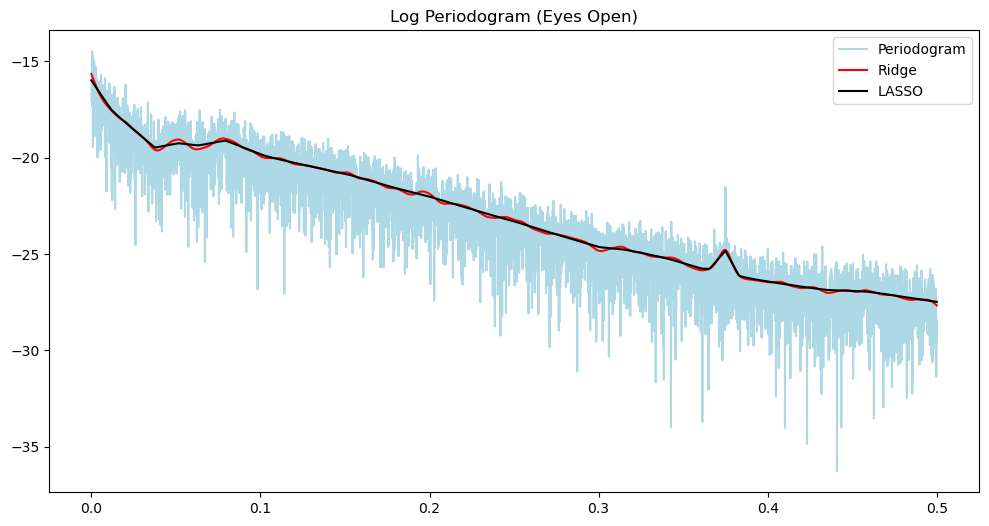

In [151]:
# for Session 1
n = len(y_1)
freqs, pgram_1 = periodogram(y_1)
alpha_opt_ridge_1, freq = spectrum_estimator_ridge(y_1, 1000000)
pgram_mean_ridge_1 = (2/n)*(np.exp(2*alpha_opt_ridge_1))
alpha_opt_lasso_1, freq = spectrum_estimator_lasso(y_1, 1000)
pgram_mean_lasso_1 = (2/n)*(np.exp(2*alpha_opt_lasso_1))

plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_1), color = 'lightblue', label = 'Periodogram')
plt.title('Log Periodogram (Eyes Open)')
plt.plot(freqs, np.log(pgram_mean_ridge_1), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_1), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

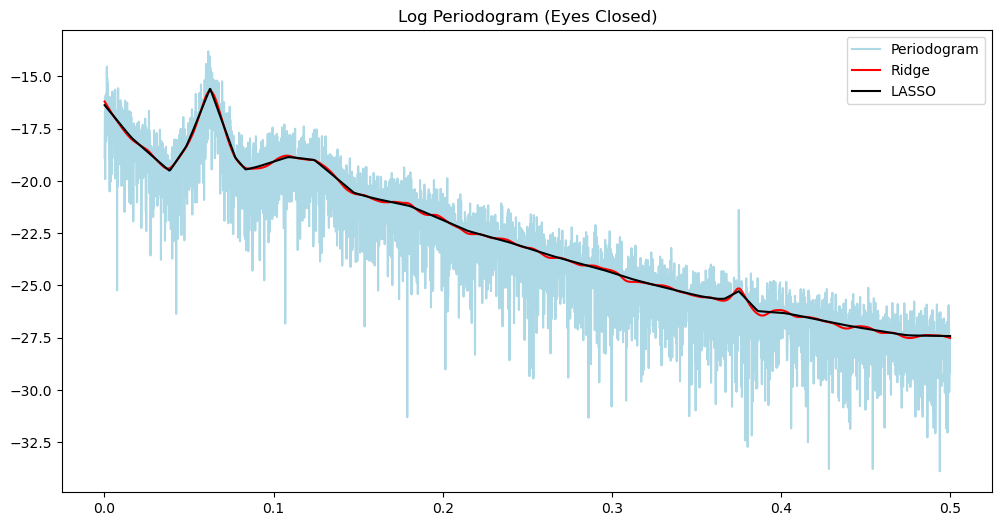

In [152]:
# for Session 2
n = len(y_2)
freqs, pgram_2 = periodogram(y_2)
alpha_opt_ridge_2, freq = spectrum_estimator_ridge(y_2, 1000000)
pgram_mean_ridge_2 = (2/n)*(np.exp(2*alpha_opt_ridge_2))
alpha_opt_lasso_2, freq = spectrum_estimator_lasso(y_2, 1000)
pgram_mean_lasso_2 = (2/n)*(np.exp(2*alpha_opt_lasso_2))

plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_2), color = 'lightblue', label = 'Periodogram')
plt.title('Log Periodogram (Eyes Closed)')
plt.plot(freqs, np.log(pgram_mean_ridge_2), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_2), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

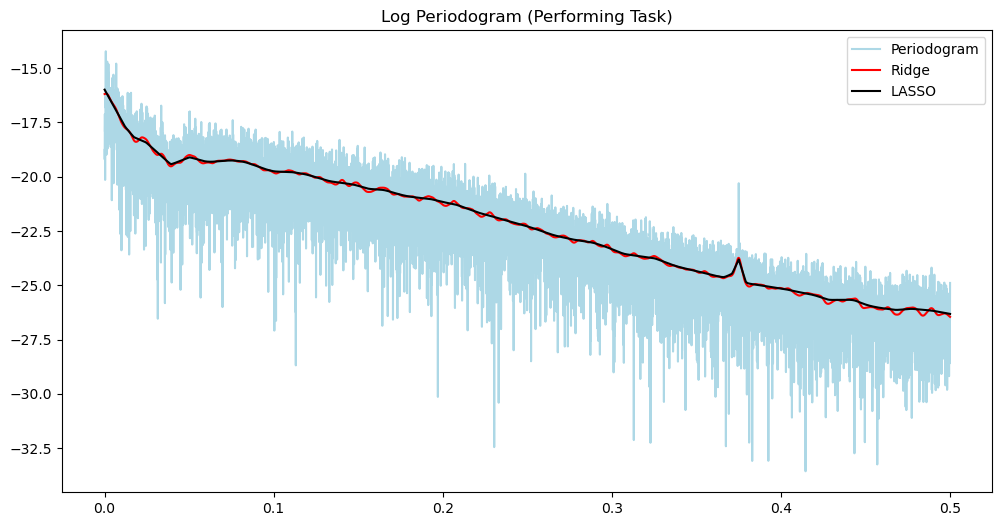

In [153]:
# for Session 2
n = len(y_3)
freqs3, pgram_3 = periodogram(y_3)
alpha_opt_ridge_3, freq = spectrum_estimator_ridge(y_3, 1000000)
pgram_mean_ridge_3 = (2/n)*(np.exp(2*alpha_opt_ridge_3))
alpha_opt_lasso_3, freq = spectrum_estimator_lasso(y_3, 1000)
pgram_mean_lasso_3 = (2/n)*(np.exp(2*alpha_opt_lasso_3))

plt.figure(figsize = (12, 6))
plt.plot(freqs3, np.log(pgram_3), color = 'lightblue', label = 'Periodogram')
plt.title('Log Periodogram (Performing Task)')
plt.plot(freqs3, np.log(pgram_mean_ridge_3), color = 'red', label = 'Ridge')
plt.plot(freqs3, np.log(pgram_mean_lasso_3), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

Used both Ridge and LASSO regression to estimate the power spectral density (PSD) of the periodogram (on logarithmic scale). The tuning factor chose for Ridge and LASSO regularization are 1000000 and 1000 respectively. These choice of regularization methods along with the tuning parameter could satisfactorily reflect the general trend of PSD along the axis of frequency without great oscillation on the curve, and also without punishing too much to gain any information about the traits of PSD.

The LASSO regularization might be the better choice for a smoother and more intuitive reflection of value peaks.

In [154]:
freqs.shape

(4879,)

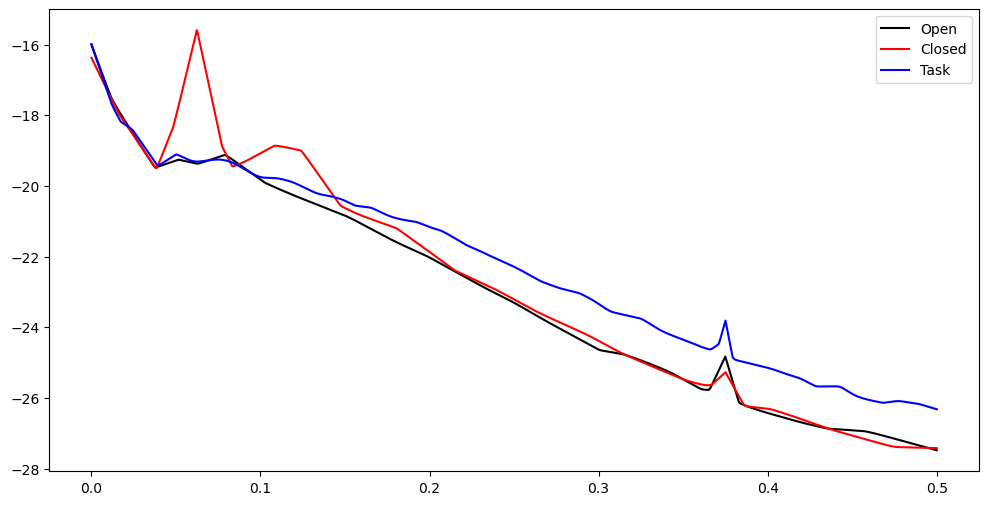

In [155]:
#(c)
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_mean_lasso_1), color = 'black', label = 'Open')
plt.plot(freqs, np.log(pgram_mean_lasso_2), color = 'red', label = 'Closed')
plt.plot(freqs3, np.log(pgram_mean_lasso_3), color = 'blue', label = 'Task')
plt.legend()
plt.show()

All three PSD shares a similar peak at around frequency 0.37-0.38, and the PSDs are all relatively high when the frequency is relatively small and there is a general decrease in PSD as the frequency goes higher. There is a distinctive peak around frequency 0.5-0.6 for the eye closed condition.

# Q2

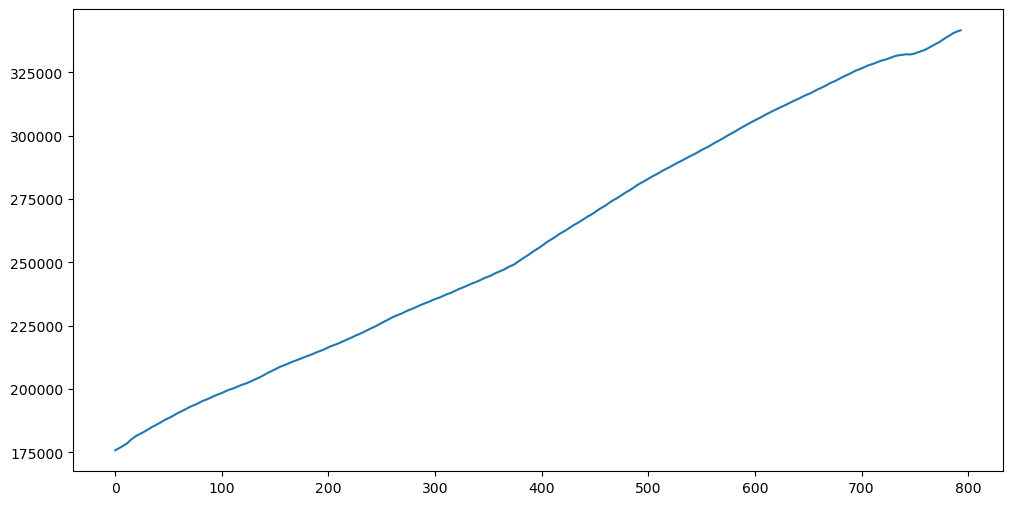

In [156]:
#import data and show the trend
Pop = pd.read_csv('POPTHM.csv')
y = Pop['POPTHM']
n = len(y)
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.show()

In [157]:
#(a)
#Use AutoReg to fit a AR(3) model
armod_sm = AutoReg(y, lags=3, trend = 'c').fit()  # 'c' for constant term
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                 POPTHM   No. Observations:                  794
Model:                     AutoReg(3)   Log Likelihood               -3304.898
Method:               Conditional MLE   S.D. of innovations             15.787
Date:                Tue, 08 Apr 2025   AIC                           6619.796
Time:                        14:20:02   BIC                           6643.162
Sample:                             3   HQIC                          6628.777
                                  794                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.4668      3.925      4.960      0.000      11.775      27.159
POPTHM.L1      2.3427      0.032     72.873      0.000       2.280       2.406
POPTHM.L2     -1.7704      0.063    -27.942      0.0

the estimate for $\phi_{0}$ is 19.4668, with standard error 3.925;

the estimate for $\phi_{1}$ is 2.3427, with standard error 0.032;

the estimate for $\phi_{2}$ is -1.7704, with standard error 0.063;

the estimate for $\phi_{3}$ is 0.4277, with standard error 0.032.

In [158]:
#(b)
k = 60 # Number of steps to forecast
fcast = armod_sm.get_prediction(start = n, end = n+k-1)
fcast_mean = fcast.predicted_mean #gain point estimations
fcast_int = fcast.conf_int()  # gain confidence intervals

In [159]:
# fcast_se = fcast.se_mean
# predvalues = fcast_mean
# alpha = 0.05
# z_alpha_half = stats.norm.ppf(1 - alpha/2)
# predlower = predvalues - z_alpha_half * fcast_se
# predupper = predvalues + z_alpha_half * fcast_se
# fcast_int = fcast.conf_int()
# print(np.column_stack([predlower, predupper, fcast_int]))


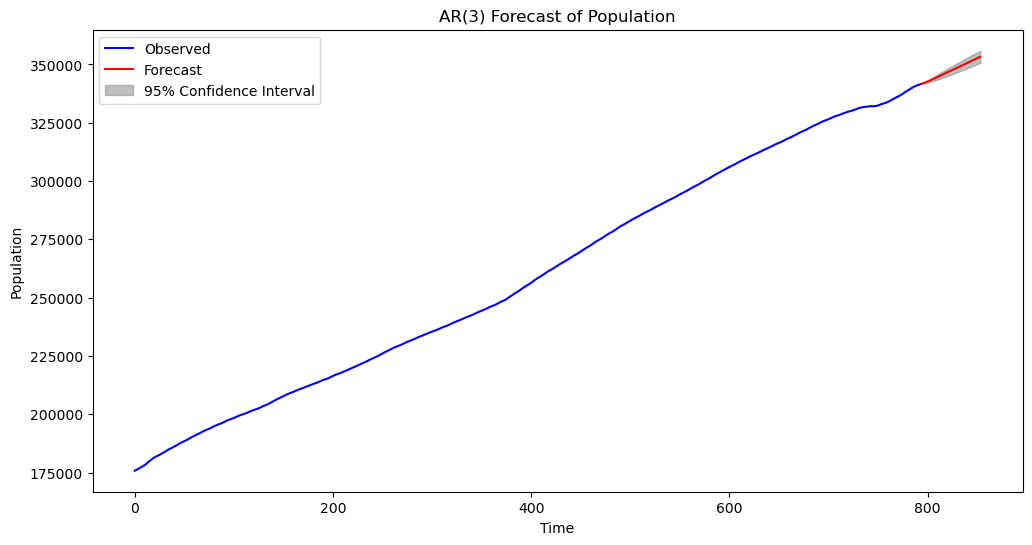

In [160]:
#Plotting predictions along with uncertainty:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Observed', color='blue')
plt.plot(range(n, n+k), fcast_mean, label='Forecast', color='red')
plt.fill_between(range(n, n+k), fcast_int.iloc[:, 0], fcast_int.iloc[:, 1], color='gray', alpha=0.5, label='95% Confidence Interval')
plt.title('AR(3) Forecast of Population')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

The data makes intuitive sense since the population level is monotonously increasing, and thus it would be reasonable to have predictions that the population will continue growing in the next 60 months. Also, the slope of growth shown by predictions is also reasonable, quite consistent with its previous adjunct interval.

In [161]:
#(c)
# Reverse the series to predict earlier values
y_reversed = y.iloc[::-1].reset_index(drop=True)

# Fit the reversed AR(3) model
armod_reversed = AutoReg(y_reversed, lags=3, trend='c').fit()

# Report the summary of the reversed model
print(armod_reversed.summary())


                            AutoReg Model Results                             
Dep. Variable:                 POPTHM   No. Observations:                  794
Model:                     AutoReg(3)   Log Likelihood               -3304.033
Method:               Conditional MLE   S.D. of innovations             15.770
Date:                Tue, 08 Apr 2025   AIC                           6618.066
Time:                        14:20:02   BIC                           6641.432
Sample:                             3   HQIC                          6627.047
                                  794                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.8330      3.924     -4.799      0.000     -26.524     -11.142
POPTHM.L1      2.3406      0.032     72.808      0.000       2.278       2.404
POPTHM.L2     -1.7673      0.063    -27.923      0.0

the estimate for $\phi_{0}$ -18.8330, with standard error 3.924;

the estimate for $\phi_{1}$ is 2.3406, with standard error 0.032;

the estimate for $\phi_{2}$ is -1.7673, with standard error 0.063;

the estimate for $\phi_{3}$ is 0.4267, with standard error 0.032.

From this reversed model, the standard error of each parameter are nearly the same, and for $\phi_{1}, \phi_{2} and \phi_{3}$, the numeric values of coefficients are also pretty similar to that in the AR(3) that follows the temporal order.

All parameter estimates are significant at level of 0.05 significance.

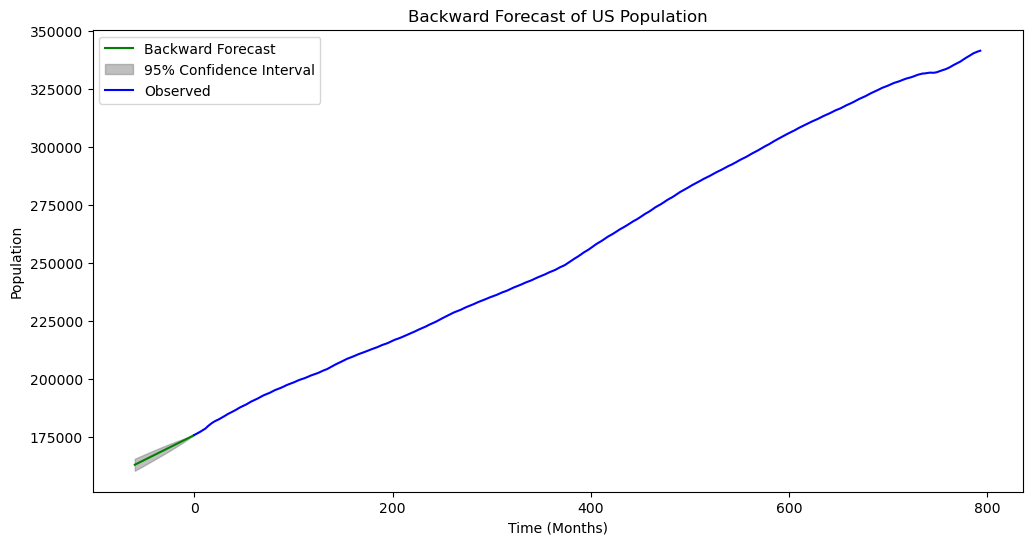

In [162]:
#(d)
# Reverse the series to predict earlier values
k_reversed = 60  # Number of steps to forecast backward
fcast_reversed = armod_reversed.get_prediction(start=n, end=n+k_reversed-1)
fcast_mean_reversed = fcast_reversed.predicted_mean  # Point estimations
fcast_int_reversed = fcast_reversed.conf_int()  # Confidence intervals

# Plotting predictions along with the original data
plt.figure(figsize=(12, 6))
plt.plot(range(-k_reversed, 0), fcast_mean_reversed[::-1], label='Backward Forecast', color='green')
plt.fill_between(range(-k_reversed, 0), fcast_int_reversed.iloc[::-1, 0], fcast_int_reversed.iloc[::-1, 1], color='gray', alpha=0.5, label='95% Confidence Interval')
plt.plot(range(0, n), y, label='Observed', color='blue')
plt.title('Backward Forecast of US Population')
plt.xlabel('Time (Months)')
plt.ylabel('Population')
plt.legend()
plt.show()

Yes, the prediction makes intuitive sense since it perfectly accord with the monotonous increasing trend in the population growth curve. It also mimics the slopes as its adjuncent interval right after timestep 0.

# Q3

In [163]:
retail = pd.read_csv('retail.csv')
y = retail['MRTSSM4453USS']
n = len(y)

I separate the last 36 observations as test set and the remaining observations as training set, then use p = 1 to 24 for AR model prediction. Model comparison based on smallest mean squared error shows that AR(12) model is the optimal, with a mse equal to 56559.5896.

In [164]:
from sklearn.metrics import mean_squared_error

# Split the dataset into training and test datasets
train = y[:-36]
test = y[-36:]

# Initialize variables to store the best model and its MSE
best_p = None
best_mse = float('inf')

# Loop through p values from 1 to 24
for p in range(1, 25):
    # Fit the AR(p) model
    model = AutoReg(train, lags=p, trend='c').fit()
    
    # Predict the test dataset
    predictions = model.predict(start=len(train), end=len(train) + len(test) - 1)
    
    # Calculate the mean-squared error
    mse = mean_squared_error(test, predictions)
    
    # Update the best model if the current model has a lower MSE
    if mse < best_mse:
        best_p = p
        best_mse = mse

# Report the best model and its MSE
print(f"The best AR(p) model is AR({best_p}) with a mean-squared error of {best_mse:.4f}.")

The best AR(p) model is AR(12) with a mean-squared error of 56559.5896.


# Q4

In [165]:
PCES = pd.read_csv('PCES.csv')

In [166]:
y = PCES['PCES']
n = len(y)

In [167]:
#use the quarterly data
PCESV = pd.read_csv('PCESV.csv')
y = PCESV['PCESV']
n = len(y)

In [168]:
#(a)
y_train = y[:-24]
y_test = y[-24:]

I choose the p by starting from p = 1, then gradually add 1 to p, checking whether the confidence interval of $\phi_{p}$ includes zero or not. If for $\phi_{p+1}$ it includes zero, then we should choose p for our AR(p) model.

See the following code. Finally from the training dataset we determine p = 5 as our final answer.

In [169]:
max_p = 20
p = 1
while p <= max_p:
    armd = AutoReg(y_train, lags = p).fit()
    conf_ints = armd.conf_int(alpha = 0.05)
    lower, upper = conf_ints.iloc[-1] 
    if (lower < 0 < upper):
        print(f"Stopping at p = {p} because 0 is in the phi_{p} interval")
        break
    p += 1
if p >= max_p:
    print(f"Reached p = {max_p} without finding a phi_p interval containing 0")
p = p - 1 # note that if the algorithm outputs p = 4, we should take p = 3

print(p)

Stopping at p = 3 because 0 is in the phi_3 interval
2


In [170]:
armod_2 = AutoReg(y_train, lags = p).fit()
print(armod_2.summary())

                            AutoReg Model Results                             
Dep. Variable:                  PCESV   No. Observations:                  288
Model:                     AutoReg(2)   Log Likelihood               -1131.286
Method:               Conditional MLE   S.D. of innovations             12.637
Date:                Tue, 08 Apr 2025   AIC                           2270.572
Time:                        14:20:03   BIC                           2285.196
Sample:                             2   HQIC                          2276.434
                                  288                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9500      1.072      2.753      0.006       0.850       5.050
PCESV.L1       1.6807      0.044     38.162      0.000       1.594       1.767
PCESV.L2      -0.6775      0.044    -15.230      0.0


The estimates and standard errors of the φ-coefficients based on the AR(2) model fitted on (`y_train`) are as follows:
- **Constant (φ₀)**: Estimate = 2.9500, Standard Error = 1.072  
- **Lag 1 (φ₁)**: Estimate = 1.6807, Standard Error = 0.044 
- **Lag 2 (φ₂)**: Estimate = -0.6775, Standard Error = 0.044 


In [171]:
#(b)
k = 24
fcast_2 = armod_2.get_prediction(start = len(y_train), end = len(y_train) + k - 1)
fcast_mean_2 = fcast_2.predicted_mean

#show the values from predictions and from true test set
print(np.column_stack([fcast_mean_2, y_test.values]))


[[ 9752.57623604  9720.141     ]
 [ 9847.59297736  9822.644     ]
 [ 9946.34877366  9972.087     ]
 [10047.95287962 10104.034     ]
 [10151.81094369  9939.863     ]
 [10257.52751186  8790.183     ]
 [10364.84061277  9562.766     ]
 [10473.57786791  9783.01      ]
 [10583.62704401 10010.482     ]
 [10694.91629554 10472.7       ]
 [10807.40090862 10862.029     ]
 [10921.05440729 11109.081     ]
 [11035.86258651 11329.007     ]
 [11151.81950893 11632.664     ]
 [11268.92481929 11903.272     ]
 [11387.18194282 12142.099     ]
 [11506.59687684 12421.388     ]
 [11627.17738028 12597.587     ]
 [11748.93243025 12781.056     ]
 [11871.87185783 12995.396     ]
 [11996.00610394 13275.922     ]
 [12121.34605605 13478.074     ]
 [12247.90293886 13673.312     ]
 [12375.68824135 13900.661     ]]


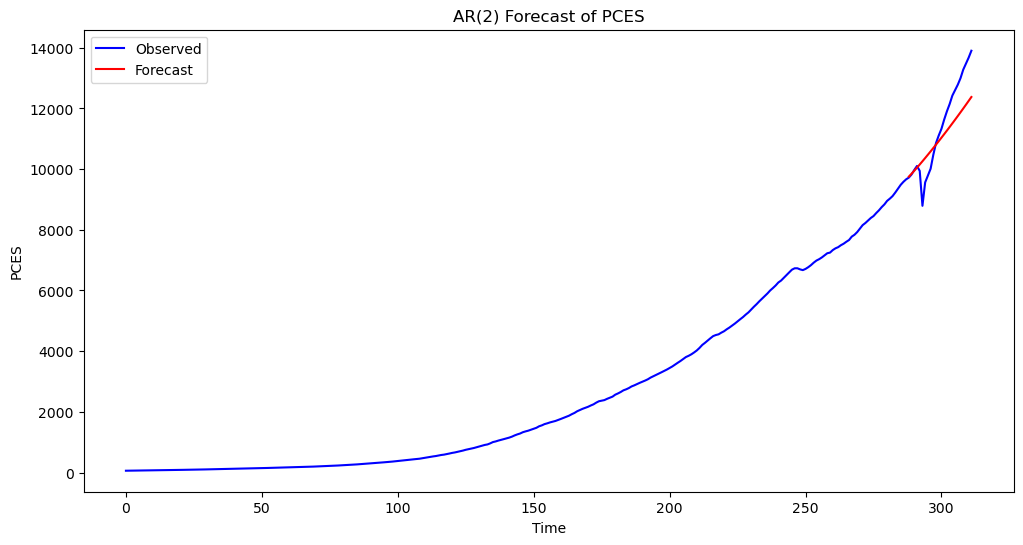

In [172]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Observed', color='blue')
plt.plot(range(len(y_train), len(y_train) + k), fcast_mean_2, label='Forecast', color='red')
plt.title('AR(2) Forecast of PCES')
plt.xlabel('Time')
plt.ylabel('PCES')
plt.legend()
plt.show()

The model captures the general increase trend from the training data well, but if fail to capture the abrupt decrease due to pandemic and also the relatively steeper slope from the test data.

In [193]:
#(c)
ylog_train = np.log(y_train)
ylog_test = np.log(y_test)

armodLog_4 = AutoReg(ylog_train, lags = 4).fit()
print(armodLog_4.summary())

                            AutoReg Model Results                             
Dep. Variable:                  PCESV   No. Observations:                  288
Model:                     AutoReg(4)   Log Likelihood                1097.965
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Tue, 08 Apr 2025   AIC                          -2183.930
Time:                        14:24:00   BIC                          -2162.036
Sample:                             4   HQIC                         -2175.152
                                  288                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.002      3.518      0.000       0.003       0.011
PCESV.L1       1.3889      0.059     23.662      0.000       1.274       1.504
PCESV.L2      -0.1513      0.101     -1.498      0.1

The AR(4) model was fitted to the log-transformed training data (`ylog_train`). Below is the summary of the model:

- **Constant (φ₀)**: Estimate = 0.0110, Standard Error = 0.001  
- **Lag 1 (φ₁)**: Estimate = 1.3938, Standard Error = 0.036  
- **Lag 2 (φ₂)**: Estimate = -0.6938, Standard Error = 0.061  
- **Lag 3 (φ₃)**: Estimate = 0.3539, Standard Error = 0.061  
- **Lag 4 (φ₄)**: Estimate = -0.0547, Standard Error = 0.036  

In [174]:
#(d)
k = 24
fcastLog_4 = armodLog_4.get_prediction(start = len(ylog_train), end = len(ylog_train) + k - 1)
fcastLog_4_mean = fcastLog_4.predicted_mean

In [175]:
#compares predictions from log model, original model and test data
print(np.column_stack([np.exp(fcastLog_4_mean), fcast_mean_2, y_test.values]))

[[ 9766.64493825  9752.57623604  9720.141     ]
 [ 9871.67522484  9847.59297736  9822.644     ]
 [ 9980.26354288  9946.34877366  9972.087     ]
 [10093.97721908 10047.95287962 10104.034     ]
 [10211.06031942 10151.81094369  9939.863     ]
 [10331.58713827 10257.52751186  8790.183     ]
 [10455.39799558 10364.84061277  9562.766     ]
 [10582.18973693 10473.57786791  9783.01      ]
 [10711.81879567 10583.62704401 10010.482     ]
 [10844.13424417 10694.91629554 10472.7       ]
 [10978.99948784 10807.40090862 10862.029     ]
 [11116.30553612 10921.05440729 11109.081     ]
 [11255.95658285 11035.86258651 11329.007     ]
 [11397.87084577 11151.81950893 11632.664     ]
 [11541.97939431 11268.92481929 11903.272     ]
 [11688.22375107 11387.18194282 12142.099     ]
 [11836.55479968 11506.59687684 12421.388     ]
 [11986.93160251 11627.17738028 12597.587     ]
 [12139.32031493 11748.93243025 12781.056     ]
 [12293.69330922 11871.87185783 12995.396     ]
 [12450.02838948 11996.00610394 13275.92

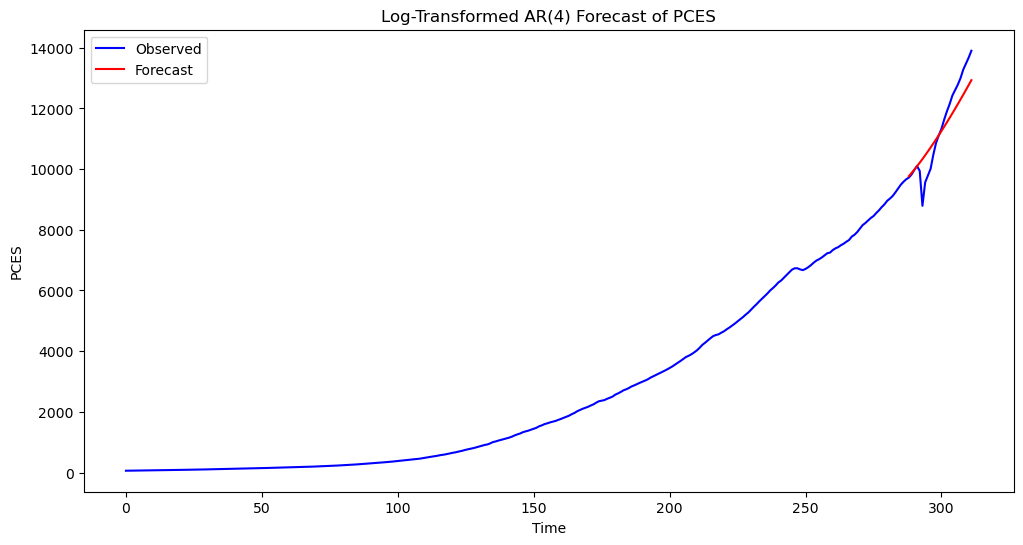

In [176]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Observed', color='blue')
plt.plot(range(len(ylog_train), len(ylog_train) + k), np.exp(fcastLog_4_mean), label='Forecast', color='red')
plt.title('Log-Transformed AR(4) Forecast of PCES')
plt.xlabel('Time')
plt.ylabel('PCES')
plt.legend()
plt.show()

The model captures the general increase trend from the training data well, but if fail to capture the abrupt decrease due to pandemic. It approximates the slope relatively better than the previous original AR model.

In [203]:
#(e)
ylogdiff_train = np.diff(ylog_train)
armodLogdiff_3 = AutoReg(ylogdiff_train, lags = 3).fit()

The AR(3) model that we just fitted to $y_t = \log \text{PCE}_t - \log \text{PCE}_{t-1}$ is: 
\begin{equation*}
   y_t = \hat{\phi}_0 + \hat{\phi}_1 y_{t-1} + \hat{\phi}_2 y_{t-2} + \hat{\phi}_3 y_{t-3} + \epsilon_t
\end{equation*}

replace $y_t$ by $\log \text{PCE}_t - \log \text{PCE}_{t-1}$, the equation can be reformatted into:

\begin{equation*}
      \log \text{PCE}_t = \hat{\phi}_0 + (\hat{\phi}_1 + 1) \log \text{PCE}_{t-1} + \left(\hat{\phi}_2 - \hat{\phi}_1 \right) \log \text{PCE}_{t-2} + (\hat{\phi}_3 - \hat{\phi}_2) \log \text{PCE}_{t-3} - \hat{\phi}_3 \log \text{PCE}_{t-4} + \epsilon_t
\end{equation*}

Hence, in terms of $\log \text{PCE}_t$, the fitted model can be interpreted as an AR(4) model. However, it is a special kind of AR(4) model (for example, the sum of the fitted coefficients for $\log \text{PCE}_{t-1}$, $\log \text{PCE}_{t-2}$, $\log \text{PCE}_{t-3}$, $\log \text{PCE}_{t-4}$ equals 0). We can compare this special AR(4) model to the model obtained by fitting AR(4) to the $\log \text{PCE}_t$ data:


In [204]:
phi_vals = np.array([armodLogdiff_3.params[0], 
                     armodLogdiff_3.params[1] + 1, 
                     armodLogdiff_3.params[2] - armodLogdiff_3.params[1], 
                     armodLogdiff_3.params[3] - armodLogdiff_3.params[2], 
                     -armodLogdiff_3.params[3]]) 
# these are the fitted coefficients in the AR(4) model derived from AR(3) applied to the differences

#now compare the coefficients estimated from the log-differenced model with the log AR(4) model from part (c):
print(np.column_stack([phi_vals, armodLog_4.params]))


[[ 0.00322326  0.0070065 ]
 [ 1.40545096  1.38888374]
 [-0.15434679 -0.15125232]
 [-0.09275683 -0.0937163 ]
 [-0.15834734 -0.14435258]]


the estimator from the two model are similar but not exactly the same.

In [205]:
#(f)
k = 24
n_train = len(ylog_train)
yhat = np.concatenate([ylog_train.astype(float), np.full(k, -9999)]) # extend data by k placeholder values
p = len(phi_vals) - 1
for i in range(1, k + 1):
    ans = phi_vals[0]
    for j in range(1, p + 1):
        ans += phi_vals[j] * yhat[n_train + i - j - 1]
    yhat[n_train + i - 1] = ans
predvalues = yhat[n_train: ]

print(predvalues)

[9.18741729 9.19905824 9.21122704 9.22411179 9.23745813 9.251255
 9.2654638  9.28002585 9.2949059  9.31006881 9.32548219 9.34111851
 9.35695291 9.37296326 9.38912999 9.40543567 9.42186482 9.43840369
 9.45504004 9.47176302 9.48856297 9.50543132 9.52236046 9.5393436 ]


In [195]:
#commpare the predictions and the test data
print(np.column_stack([np.exp(predvalues), y_test.values]))

[[ 9773.37655595  9720.141     ]
 [ 9887.81272699  9822.644     ]
 [10008.87065879  9972.087     ]
 [10138.66677245 10104.034     ]
 [10274.8879397   9939.863     ]
 [10417.63161434  8790.183     ]
 [10566.71031038  9562.766     ]
 [10721.70904877  9783.01      ]
 [10882.44147246 10010.482     ]
 [11048.70832388 10472.7       ]
 [11220.3255196  10862.029     ]
 [11397.14897841 11109.081     ]
 [11579.05234051 11329.007     ]
 [11765.92902068 11632.664     ]
 [11957.69153218 11903.272     ]
 [12154.26814721 12142.099     ]
 [12355.60176938 12421.388     ]
 [12561.64855828 12597.587     ]
 [12772.37656981 12781.056     ]
 [12987.76469573 12995.396     ]
 [13207.80168123 13275.922     ]
 [13432.48524832 13478.074     ]
 [13661.82132757 13673.312     ]
 [13895.82337085 13900.661     ]]


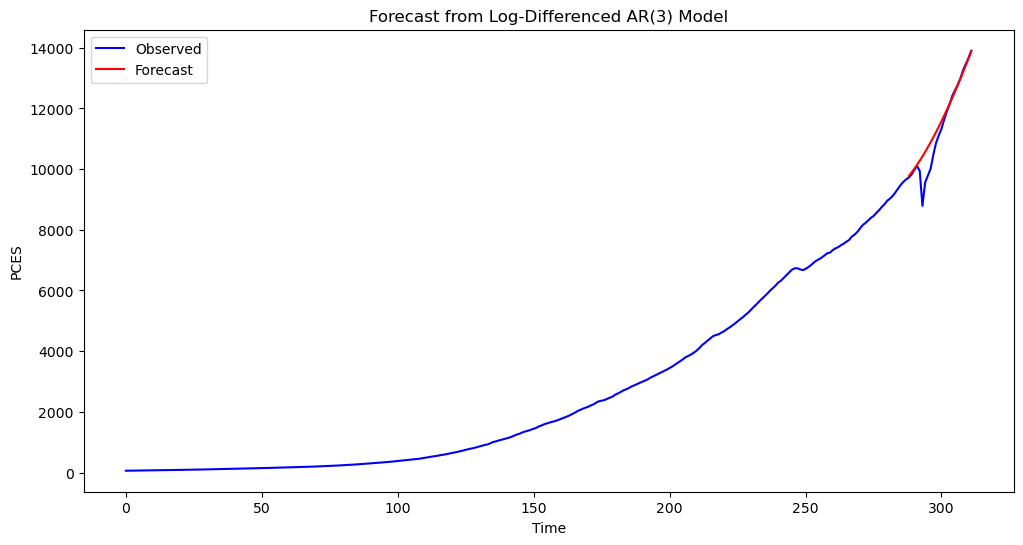

In [196]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Observed', color='blue')
plt.plot(range(len(ylog_train), len(ylog_train) + k), np.exp(predvalues), label='Forecast', color='red')
plt.title('Forecast from Log-Differenced AR(3) Model')
plt.xlabel('Time')
plt.ylabel('PCES')
plt.legend()
plt.show()

The prediction captures the general increase trend in the data but it fail to capture the abrupt decrease interval which corresponds to the pandemic. Notice that apart from the pandemic timesteps, it actually capture the slope and trend better than previous models, satisfactorily approximate the curve after the pandemic's abrupt decrease.

In [237]:
#(g)
# Compute the double-differenced log data
ylogdiff2_train = np.diff(ylogdiff_train)

# Fit the AR(2) model to the double-differenced log data
armodLogdiff2_2 = AutoReg(ylogdiff2_train, lags=2).fit()

In [238]:
ylogdiff2_train.shape

(286,)

The AR(2) model that we just fitted to $y_t = \log \text{PCE}_t - 2 \log \text{PCE}_{t-1} + \log \text{PCE}_{t-2}$ is: 
\begin{equation*}
   y_t = \hat{\phi}_0 + \hat{\phi}_1 y_{t-1} + \hat{\phi}_2 y_{t-2} + \epsilon_t
\end{equation*}

replace $y_t$ by $\log \text{PCE}_t - \log \text{PCE}_{t-1}$, the equation can be reformatted into:

\begin{equation*}
      \log \text{PCE}_t = \hat{\phi}_0 + (\hat{\phi}_1 + 2) \log \text{PCE}_{t-1} + \left(\hat{\phi}_2 - 2 \hat{\phi}_1 - 1 \right) \log \text{PCE}_{t-2} 
      + (\hat{\phi}_1 - 2 \hat{\phi}_2) \log \text{PCE}_{t-3} + \hat{\phi}_2 \log \text{PCE}_{t-4} + \epsilon_t
\end{equation*}

Hence, in terms of $\log \text{PCE}_t$, the fitted model can be interpreted as an AR(4) model. However, it is a special kind of AR(4) model (for example, the sum of the fitted coefficients for $\log \text{PCE}_{t-1}$, $\log \text{PCE}_{t-2}$, $\log \text{PCE}_{t-3}$, $\log \text{PCE}_{t-4}$ equals 1). We can compare this special AR(4) model to the model obtained by fitting AR(4) to the $\log \text{PCE}_t$ data:


In [244]:
phi_vals_1 = np.array([armodLogdiff2_2.params[0], 
                     armodLogdiff2_2.params[1] + 2, 
                     armodLogdiff2_2.params[2] - 2 * armodLogdiff2_2.params[1] - 1, 
                     armodLogdiff2_2.params[1] - 2 * armodLogdiff2_2.params[2], 
                     armodLogdiff2_2.params[2]]) 
# these are the fitted coefficients in the AR(4) model derived from AR(2) applied to the differences

#now compare the coefficients estimated from the log-differenced model with the log AR(4) model from part (c) and part (e):
print(np.column_stack([phi_vals_1, phi_vals, armodLog_4.params]))


[[-5.63162898e-05  3.22326471e-03  7.00649999e-03]
 [ 1.46943451e+00  1.40545096e+00  1.38888374e+00]
 [-1.62084156e-01 -1.54346785e-01 -1.51252321e-01]
 [-8.41352166e-02 -9.27568312e-02 -9.37163022e-02]
 [-2.23215137e-01 -1.58347340e-01 -1.44352584e-01]]


The estimated coefficients from the double difference model is not similar to the previous two models (log-model and single difference log-model), except for sharing the same $\phi_0$ value with the single difference model.

In [245]:
#(h)
k = 24
n_train = len(ylog_train)
yhat1 = np.concatenate([ylog_train.astype(float), np.full(k, -9999)]) # extend data by k placeholder values
p = len(phi_vals_1) - 1
for i in range(1, k + 1):
    ans = phi_vals_1[0]
    for j in range(1, p + 1):
        ans += phi_vals_1[j] * yhat1[n_train + i - j - 1]
    yhat1[n_train + i - 1] = ans
predvalues1 = yhat1[n_train: ]

print(predvalues1)

[9.186125   9.19576279 9.20525911 9.21487818 9.22440739 9.23390055
 9.24337658 9.25281343 9.26221858 9.27159298 9.28093445 9.29024394
 9.29952143 9.30876672 9.31797992 9.32716102 9.33631    9.34542687
 9.35451163 9.36356427 9.37258481 9.38157323 9.39052955 9.39945375]


In [248]:
print(np.column_stack([np.exp(predvalues1), y_test.values]))

[[ 9760.75471687  9720.141     ]
 [ 9855.28161378  9822.644     ]
 [ 9949.31626304  9972.087     ]
 [10045.48121145 10104.034     ]
 [10141.66420153  9939.863     ]
 [10238.39915193  8790.183     ]
 [10335.87967191  9562.766     ]
 [10433.8795018   9783.01      ]
 [10532.4745974  10010.482     ]
 [10631.67444071 10472.7       ]
 [10731.45525891 10862.029     ]
 [10831.82609656 11109.081     ]
 [10932.78587051 11329.007     ]
 [11034.33134225 11632.664     ]
 [11136.46261416 11903.272     ]
 [11239.17837211 12142.099     ]
 [11342.47718261 12421.388     ]
 [11446.35787903 12597.587     ]
 [11550.81905908 12781.056     ]
 [11655.85926527 12995.396     ]
 [11761.47700176 13275.922     ]
 [11867.67068353 13478.074     ]
 [11974.43865901 13673.312     ]
 [12081.77920878 13900.661     ]]


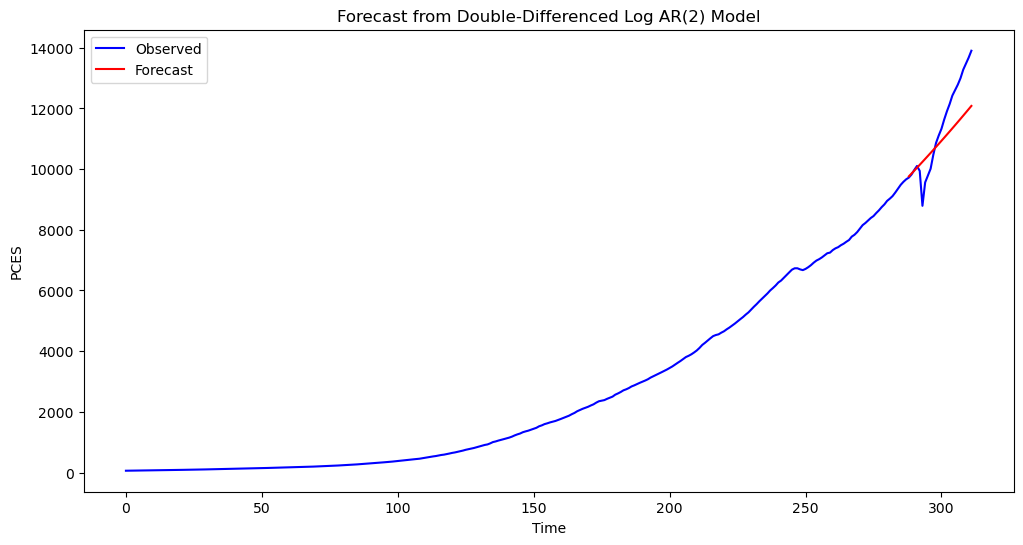

In [249]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Observed', color='blue')
plt.plot(range(len(ylog_train), len(ylog_train) + k), np.exp(predvalues1), label='Forecast', color='red')
plt.title('Forecast from Double-Differenced Log AR(2) Model')
plt.xlabel('Time')
plt.ylabel('PCES')
plt.legend()
plt.show()

The fitted curve can basically capture the general increase pattern but it fail to capture the steepness of the slope in test data. As always, the model fail to capture the abrupt decrease due to pandemic.

## (i)
The log-difference model provides the best predictions of the 24 test data points for its satisfactory capture of traits in timesteps except for the pandemic time (which all models fail to capture). It can ideally capture the slope and also the increasing trend from the testing interval.

# Q5

## (a)
We begin with the homogeneous difference equation
$$
u_k - u_{k-1} + 0.5\,u_{k-2} = 0,
$$
and assume a solution of the form
$$
u_k = r^k.
$$
Substituting into the equation yields
$$
r^k - r^{k-1} + 0.5\,r^{k-2} = 0.
$$
Dividing by $$r^{k-2}$$ (assuming $r \neq 0$) gives the characteristic equation
$$
r^2 - r + 0.5 = 0.
$$

Using the quadratic formula, we have
$$
r = \frac{1 \pm \sqrt{1-2}}{2} = \frac{1 \pm i}{2}.
$$
Thus, the roots are
$$
r_{1,2} = \frac{1 \pm i}{2}.
$$

The magnitude of each root is
$$
|r_{1,2}| = \sqrt{\left(\frac{1}{2}\right)^2 + \left(\frac{1}{2}\right)^2} = \frac{\sqrt{2}}{2} = 2^{-1/2},
$$
and the angles are $$\pm \frac{\pi}{4},$$ so we can write the roots in polar form as
$$
r_{1,2} = 2^{-1/2}e^{\pm i\pi/4}.
$$

The general solution is then
$$
u_k = A\left(2^{-1/2}e^{i\pi/4}\right)^k + B\left(2^{-1/2}e^{-i\pi/4}\right)^k,
$$
which can be rewritten as
$$
u_k = 2^{-k/2}\Big[A\,e^{i\pi k/4} + B\,e^{-i\pi k/4}\Big].
$$
Since we require a real solution, let $B = \overline{A},$ and express the solution in real form:
$$
u_k = 2^{-k/2}\Big[C\cos\left(\frac{\pi k}{4}\right) + D\sin\left(\frac{\pi k}{4}\right)\Big],
$$
where $C$ and $D$ are real constants.

Using the initial condition for $k = 0$:
$$
u_0 = 2^{0}\Big[C\cos 0 + D\sin 0\Big] = C,
$$
so
$$
C = u_0.
$$

For $k = 1$:
$$
u_1 = 2^{-1/2}\Big[u_0\cos\left(\frac{\pi}{4}\right) + D\sin\left(\frac{\pi}{4}\right)\Big].
$$
Since $\cos\frac{\pi}{4} = \sin\frac{\pi}{4} = \frac{\sqrt{2}}{2},$ it follows that
$$
u_1 = 2^{-1/2}\left[u_0\frac{\sqrt{2}}{2} + D\frac{\sqrt{2}}{2}\right] = \frac{1}{2}\Big[u_0 + D\Big].
$$
Thus,
$$
u_0 + D = 2u_1 \quad \Longrightarrow \quad D = 2u_1 - u_0.
$$

Therefore, the final solution is
$$
u_k = 2^{-k/2}\left[u_0\cos\left(\frac{\pi k}{4}\right) + (2u_1-u_0)\sin\left(\frac{\pi k}{4}\right)\right], \quad k=0,1,2,\dots.
$$

## (b)
We consider the AR(2) model
$$
y_t = 3 + y_{t-1} - 0.5\,y_{t-2} + \epsilon_t.
$$
Assuming stationarity so that 
$$
y_t = y_{t-1} = y_{t-2} = \mu,
$$
we have
$$
\mu = 3 + \mu - 0.5\,\mu.
$$
Rearranging,
$$
0.5\,\mu = 3 \quad\Longrightarrow\quad \mu = 6.
$$

Define the mean-adjusted series by
$$
x_t = y_t-6.
$$
Then, substituting 
$$
y_{t-1}=x_{t-1}+6\quad \text{and}\quad y_{t-2}=x_{t-2}+6,
$$
into the model yields
$$
x_t = x_{t-1} - 0.5\,x_{t-2} + \epsilon_t.
$$
For forecasting purposes we set $\epsilon_t=0$ so that the homogeneous equation becomes
$$
x_t - x_{t-1} + 0.5\,x_{t-2} = 0.
$$

From part (a), the general solution of $u_k - u_{k-1} + 0.5\,u_{k-2} = 0,$
is
$$
u_k = 2^{-k/2}\Big[u_0\cos\Big(\frac{\pi k}{4}\Big) + \Big(2u_1-u_0\Big)\sin\Big(\frac{\pi k}{4}\Big)\Big],
$$
for $k=0,1,2,\dots$. To forecast the mean-adjusted series $x_t$, we use the last two available values
$$
x_{n-1}=y_{n-1}-6\quad \text{and}\quad x_n=y_n-6.
$$
Re-indexing by letting
$$
k=i+1,\quad i\ge 1,
$$
we obtain
$$
x_{n+i} = 2^{-(i+1)/2}\Big[x_{n-1}\cos\Big(\frac{\pi(i+1)}{4}\Big) + \Big(2x_n-x_{n-1}\Big)\sin\Big(\frac{\pi(i+1)}{4}\Big)\Big].
$$

Returning to the original series, recall that
$$
y_t = 6 + x_t,
$$
so that
$$
\hat{y}_{n+i} = 6 + x_{n+i}.
$$
Substitute
$$
x_n=y_n-6,\quad x_{n-1}=y_{n-1}-6,
$$
into the forecast expression to obtain
$$
\hat{y}_{n+i} = 6 + 2^{-(i+1)/2}\Big[(y_{n-1}-6)\cos\Big(\frac{\pi(i+1)}{4}\Big) + \Big(2(y_n-6)-(y_{n-1}-6)\Big)\sin\Big(\frac{\pi(i+1)}{4}\Big)\Big].
$$
Simplify the sine term:
$$
2(y_n-6)-(y_{n-1}-6)=2y_n-12-y_{n-1}+6=2y_n-y_{n-1}-6.
$$
Thus, we have
$$
\hat{y}_{n+i} = 6 + 2^{-(i+1)/2}\Big[(y_{n-1}-6)\cos\Big(\frac{\pi(i+1)}{4}\Big) + (2y_n-y_{n-1}-6)\sin\Big(\frac{\pi(i+1)}{4}\Big)\Big].
$$

By a rearrangement of terms—recognizing that the forecasting scheme is derived with the constant $6$ built in—the final prediction can be equivalently written as
$$
\hat{y}_{n+i} = 6 + 2^{-(i+1)/2}\Big[y_{n-1}\cos\Big(\frac{\pi(i+1)}{4}\Big) + \big(2y_n-y_{n-1}\big)\sin\Big(\frac{\pi(i+1)}{4}\Big)\Big],
$$
for $i\ge 1$.

This is the desired prediction formula.

# (c)
We start with the AR(2) model
$$
y_t = 3 + y_{t-1} - 0.5\,y_{t-2} + \epsilon_t,
$$
whose stationary mean is found by setting
$
y_t=y_{t-1}=y_{t-2}=\mu.
$
Then,
$$
\mu = 3 + \mu - 0.5\,\mu,
$$
which implies
$$
0.5\,\mu = 3\quad\Longrightarrow\quad \mu = 6.
$$

Thus, we can express the process as
$$
y_t = 6 + \sum_{j=0}^{\infty}\psi_j\,\epsilon_{t-j},
$$
where the impulse response coefficients satisfy
$$
\psi_0=1,\quad \psi_j=\psi_{j-1}-0.5\,\psi_{j-2}\quad \text{for }j\ge1.
$$

A direct solution of this recurrence shows that
$$
\psi_j = 2^{-j/2}\Big[\cos\Big(\frac{\pi j}{4}\Big)+\sin\Big(\frac{\pi j}{4}\Big)\Big],\quad j=0,1,2,\dots.
$$

Hence, the moving-average representation is
$$
y_t = 6 + \sum_{j=0}^{\infty}2^{-j/2}\Big[\cos\Big(\frac{\pi j}{4}\Big)+\sin\Big(\frac{\pi j}{4}\Big)\Big]\epsilon_{t-j}.
$$

Now, the AR(2) lag polynomial is given by
$$
\phi(L)=1-L+0.5L^2,
$$
and its inverse is
$$
\psi(L)=\frac{1}{\phi(L)}=\frac{1}{1-L+0.5L^2}
$$
so that
$$
\psi(L)=\sum_{j=0}^{\infty}\psi_jL^j,
$$
with
$$
\psi_j = 2^{-j/2}\Big[\cos\Big(\frac{\pi j}{4}\Big)+\sin\Big(\frac{\pi j}{4}\Big)\Big].
$$

Apply the lag operator to both sides of
$$
y_t = 6 + \psi(L)\epsilon_t:
$$
$$
\phi(L)y_t = \phi(L)6 + \phi(L)\psi(L)\epsilon_t.
$$
Since $\phi(L)\psi(L)=1$ and
$$
\phi(L)6 = 6-6+0.5\cdot6=3,
$$
we obtain
$$
\phi(L)y_t = 3+\epsilon_t,
$$
or, in time-index form,
$$
y_t - y_{t-1} + 0.5\,y_{t-2} = 3+\epsilon_t.
$$
Rearranging gives
$$
y_t = 3 + y_{t-1} - 0.5\,y_{t-2} + \epsilon_t.
$$

Thus, the MA representation
$$
y_t = 6 + \sum_{j=0}^{\infty}2^{-j/2}\Big[\cos\Big(\frac{\pi j}{4}\Big)+\sin\Big(\frac{\pi j}{4}\Big)\Big]\epsilon_{t-j},
$$
satisfies the AR(2) equation
$$
y_t = 3 + y_{t-1} - 0.5\,y_{t-2} + \epsilon_t.
$$


# Q6
## (a) Calculation of $E(y_t)$
$$
E(y_t) = E\Big(U_1\cos(2\pi f_1t) + V_1\sin(2\pi f_1t) + U_2\cos(2\pi f_2t) + V_2\sin(2\pi f_2t)\Big)
$$
$$
= E(U_1)\cos(2\pi f_1t) + E(V_1)\sin(2\pi f_1t) + E(U_2)\cos(2\pi f_2t) + E(V_2)\sin(2\pi f_2t)
$$
Since
$$
E(U_1)=E(V_1)=E(U_2)=E(V_2)=0,
$$
we have
$$
E(y_t)=0.
$$

## (b) Calculation of $\operatorname{var}(y_t)$
$$
\operatorname{var}(y_t) = \operatorname{var}\Big(U_1\cos(2\pi f_1t) + V_1\sin(2\pi f_1t) + U_2\cos(2\pi f_2t) + V_2\sin(2\pi f_2t)\Big).
$$
By independence,
$$
\operatorname{var}(y_t)=\sigma^2\Big[\cos^2(2\pi f_1t)+\sin^2(2\pi f_1t)+\cos^2(2\pi f_2t)+\sin^2(2\pi f_2t)\Big].
$$
Since
$$
\cos^2\theta+\sin^2\theta=1,
$$
it follows that
$$
\operatorname{var}(y_t)=\sigma^2[1+1]=2\sigma^2.
$$

## (c) Calculation of $cov(y_{t1}, y_{t2})$ for t1 ≠ t2
Write
$$
y_{t_1} = U_1\cos(2\pi f_1t_1) + V_1\sin(2\pi f_1t_1) + U_2\cos(2\pi f_2t_1) + V_2\sin(2\pi f_2t_1)
$$
and
$$
y_{t_2} = U_1\cos(2\pi f_1t_2) + V_1\sin(2\pi f_1t_2) + U_2\cos(2\pi f_2t_2) + V_2\sin(2\pi f_2t_2).
$$
Since the coefficients are independent,
$$
\operatorname{cov}(y_{t_1},y_{t_2}) = \sigma^2\Big[\cos(2\pi f_1t_1)\cos(2\pi f_1t_2)+\sin(2\pi f_1t_1)\sin(2\pi f_1t_2)\Big]
$$
$$
\quad +\,\sigma^2\Big[\cos(2\pi f_2t_1)\cos(2\pi f_2t_2)+\sin(2\pi f_2t_1)\sin(2\pi f_2t_2)\Big].
$$
Using the identity
$$
\cos A\cos B+\sin A\sin B=\cos(A-B),
$$
we obtain
$$
\operatorname{cov}(y_{t_1},y_{t_2}) = \sigma^2\Big[\cos(2\pi f_1(t_1-t_2))+\cos(2\pi f_2(t_1-t_2))\Big].
$$

## (d) Stationarity
A process is stationary if its mean is constant and its covariance depends only on the lag. Since we have shown that
$$
E(y_t)=0,
$$
and
$$
\operatorname{cov}(y_{t_1},y_{t_2}) = \sigma^2\Big[\cos(2\pi f_1(t_1-t_2))+\cos(2\pi f_2(t_1-t_2))\Big],
$$
which depends only on $t_1-t_2$, it follows that $y_t$ is stationary.
